# RESTAURANT - Feature Engineering and Models

In [1]:
from scipy import stats
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import os
import statsmodels.api as sm
import matplotlib.transforms as mtransforms
from scipy import stats
import warnings
from statsmodels.tsa.stattools import adfuller
from IPython.display import Image
import logging
from fbprophet import Prophet
import warnings
warnings.simplefilter('ignore')
import multiprocessing
from multiprocessing import Pool

warnings.simplefilter('ignore')

In [2]:
# global vars
# plt.rcParams.keys()
plt.rcParams['grid.linestyle'] ='--'
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['figure.figsize'] = [7,3]
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.titleweight"] = "bold"

sns.set_palette("PRGn", 10)

In [3]:
%matplotlib inline

In [4]:
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# IMPORT DATA

In [5]:
path_input = ('../input/')

In [6]:
air_visits = pd.read_csv(os.path.join(path_input,'air_visit_data.csv.gz'))
air_reserve = pd.read_csv(os.path.join(path_input,'air_reserve.csv.gz'))
hpg_reserve = pd.read_csv(os.path.join(path_input,'hpg_reserve.csv.gz'))
air_store = pd.read_csv(os.path.join(path_input,'air_store_info.csv.gz'))
hpg_store = pd.read_csv(os.path.join(path_input,'hpg_store_info.csv.gz'))
holidays = pd.read_csv(os.path.join(path_input,'date_info.csv.gz'))
store_ids = pd.read_csv(os.path.join(path_input,'store_id_relation.csv.gz'))
test = pd.read_csv(os.path.join(path_input,'sample_submission.csv.gz'))

In [7]:
holidays = holidays.rename(columns={'calendar_date':'visit_date'})

In [8]:
tables = [('air_visits',air_visits),
        ('air_reserve',air_reserve),
        ('hpg_reserve',hpg_reserve),
        ('air_store',air_store),
        ('hpg_store',hpg_store),
        ('holidays',holidays),
        ('store_ids',store_ids,),
        ('test',test)]

# BASELINE MODELS  (without training algorithms)

In [9]:
test['visit_date'] = test.id.apply(lambda x: x.split('_')[-1])

test['air_store_id']= test.id.apply(lambda x: '_'.join(x.split('_')[:2]))

## 1 Using Median

By considering data is skewed, and there are outliers, using median is a better idea. Median is more robust than mean.

In [10]:
median_model = air_visits.groupby(['air_store_id'])['visitors'].median().reset_index()

median_model.head()

,air_store_id,visitors
0,air_00a91d42b08b08d9,26.0
1,air_0164b9927d20bcc3,8.0
2,air_0241aa3964b7f861,9.0
3,air_0328696196e46f18,6.0
4,air_034a3d5b40d5b1b1,12.0


In [11]:
median_test = test[['id','air_store_id']].merge(median_model, how='left', on='air_store_id')

median_test.head()

,id,air_store_id,visitors
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,26.0
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,26.0
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,26.0
3,air_00a91d42b08b08d9_2017-04-26,air_00a91d42b08b08d9,26.0
4,air_00a91d42b08b08d9_2017-04-27,air_00a91d42b08b08d9,26.0


In [12]:
# median_test[['id','visitors']].to_csv('./submissions/median_baseline.csv', index=False)

# BASELINE SUBMISSION 
private:0.623 public:0.605

# 2. Forecasting with Time Series Analysis

## 2. i.  Seasonal ARIMA with STATSMODELS Library

statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The package is released under the open source Modified BSD (3-clause) license. The online documentation is hosted at statsmodels.org.



http://conference.scipy.org/proceedings/scipy2010/pdfs/seabold.pdf

## Seasnoal Auto Regressive Integrated Moving Aaverage
A popular method for forecasting is the autoregressive integrated moving average model; short ARIMA model. This kind of model consists of three building blocks which parametrised by the three indeces p, d, q as ARIMA(p, d, q):

auto-regressive / p: we are using past data to compute a regression model for future data. The parameter p indicates the range of lags; e.g. ARIMA(3,0,0) includes t-1, t-2, and t-3 values in the regression to compute the value at t.

integrated / d: this is a differencing parameter, which gives us the number of times we are subtracting the current and the previous values of a time series. Differencing removes the change in a time series in that it stabilises the mean and removes (seasonal) trends. This is necessary since computing the lags (e.g. difference between time t and time t-1) is most meaningful if large-scale trends are removed. A time series where the variance (or amount of variability) (and the autocovariance) are time-invariant (i.e. don’t change from day to day) is called stationary.

moving average / q: this parameter gives us the number of previous error terms to include in the regression error of the model.

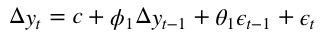

In [120]:
Image("stored_files/arima.png", width=400, height=400)

In [13]:
air_visits['visit_date'] = pd.to_datetime(air_visits['visit_date'])

In [14]:
air=air_visits.set_index('visit_date')
df2=pd.DataFrame()
df2['visit_total'] = air.groupby(air.index,sort=True)['visitors'].sum()
df2['visit_mean'] = air.groupby(air.index,sort=True)['visitors'].mean()
df2['reserv_cnt'] = air.groupby(air.index,sort=True)['visitors'].count()
air=df2;del df2

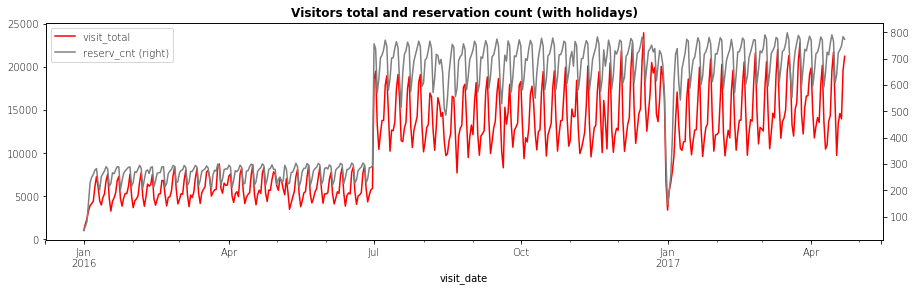

In [15]:
air['visit_total'].plot(legend=True,c='r');
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True,
                      title='Visitors total and reservation count (with holidays)',
                      c='gray');

    - Notice the huge increase in July 2016 (see above). The drop comes because many restaurants did not have any data before that month. Probably the registration system started "monitoring" many new restaurants/stores in that period.


In [16]:
holidays['visit_date'] = pd.to_datetime(holidays['visit_date'])

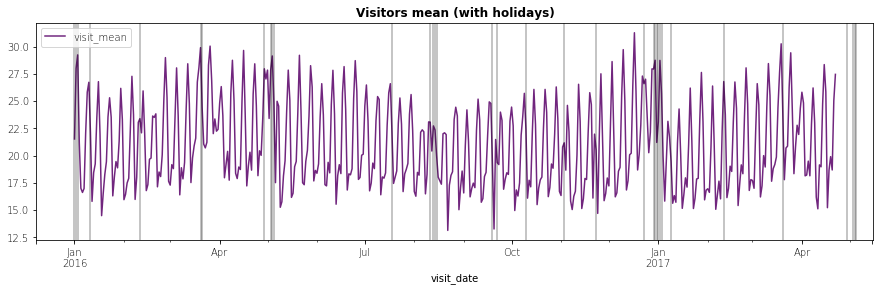

In [17]:
air['visit_mean'].plot(figsize=(15,4), legend=True, title='Visitors mean (with holidays)')

for x in holidays.query('holiday_flg==1')['visit_date']:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

    -instead of the sum of visits, a better measurement is the mean of the cumulative visits

## Prerequisite for ARMA 
To apply ARMA model data must be stationary and invertable.

**Stationary**:Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

**Non-Stationary Time Series**:Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.

Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.

Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.



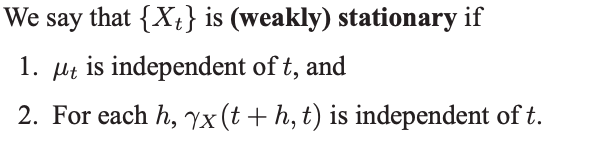

In [18]:
Image("stored_files/stationary_def.png", width=400, height=400)

<Figure size 432x288 with 0 Axes>

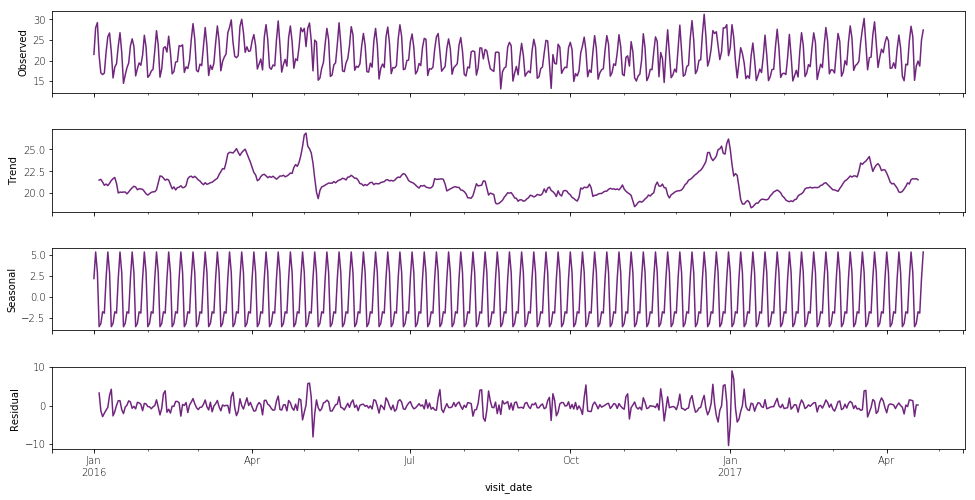

In [19]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition using moving averages
# The additive model is Y[t] = T[t] + S[t] + e[t]
decomposition = seasonal_decompose(air.visit_mean, freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

#### Augmented Dickey-Fuller test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

**p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

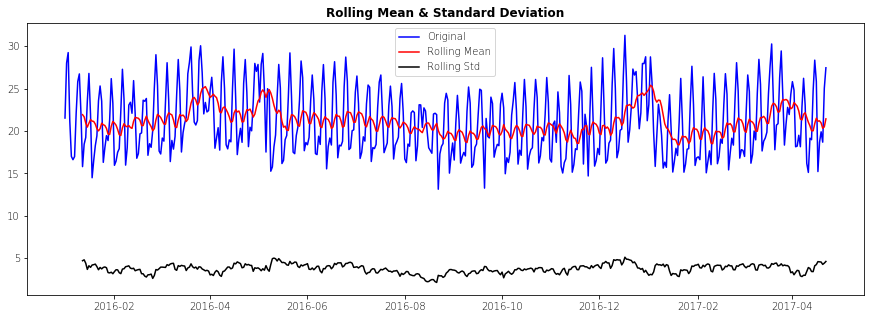

Results of Dickey-Fuller Test:
Test Statistic                  -3.796104
p-value                          0.002947
#Lags Used                      16.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


In [21]:
test_stationarity(air.visit_mean); #-3.796104

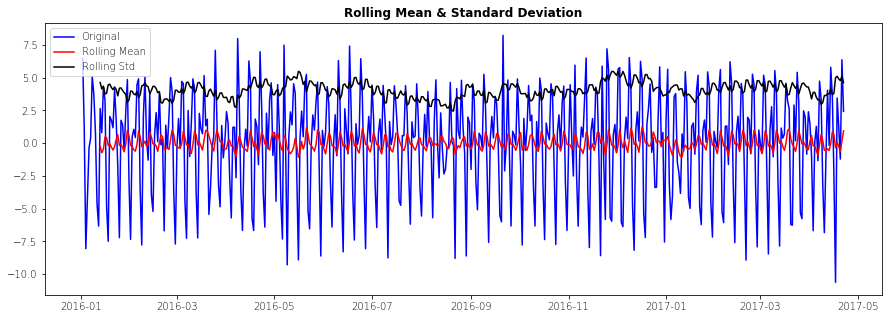

Results of Dickey-Fuller Test:
Test Statistic                -6.608968e+00
p-value                        6.448883e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (1%)           -3.444709e+00
Critical Value (5%)           -2.867871e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


In [22]:
# Although I see no real global trend, 1st difference strongly improves stationarity
air['visit_mean_diff'] = air.visit_mean - air.visit_mean.shift(1) 
test_stationarity(air.visit_mean_diff.dropna(inplace=False)) #-6.608968e+00

# MODEL

#### AIC
The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

We can consider model selection using the Akaike information criteria (AIC), but running the model for each variant and selecting the model with the lowest AIC value.

In [23]:
import warnings

warnings.simplefilter('ignore')

def ARIMA_grid_search(X):
    aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))

    # Iterate over all ARMA(p,q) models with p,q in [0,6]
    for p in range(6):
        for q in range(6):
            if p == 0 and q == 0:
                continue

            # Estimate the model with no missing datapoints
            mod = sm.tsa.statespace.SARIMAX(X,trend='c',
                                            order=(p,1,q),
                                            seasonal_order=(0,1,0,7))
            try:
                res = mod.fit(disp=False)
                aic_full.iloc[p,q] = res.aic
            except:
                aic_full.iloc[p,q] = np.nan
    
    return(aic_full)

In [24]:
forecast_days = 39

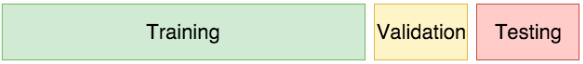

In [122]:
Image("stored_files/cv.png", width=400, height=400)

In [26]:
train_visit_mean = air['visit_mean'][:-forecast_days]
cv_visit_mean = air['visit_mean'][-forecast_days:]

In [27]:
# train_visit_mean = air.loc[:'2016-04-21','visit_mean']
# cv_visit_mean = air.loc['2016-04-22':'2016-05-30','visit_mean']
# train_visit_mean = air.loc[:'2016-12-25','visit_mean']
# cv_visit_mean = air.loc['2016-12-26':'2017-02-02','visit_mean']
# train_visit_mean = air_sub.loc[:'2016-12-25']
# cv_visit_mean = air_sub.loc['2016-12-26':'2017-02-02']
# train_visit_mean = air_sub[:-forecast_days]
# cv_visit_mean = air_sub[-forecast_days:]

In [28]:
%%time
aic_full = ARIMA_grid_search(train_visit_mean)
display(aic_full)

,0,1,2,3,4,5
0,0.000000,2077.390071,1981.028241,1977.401626,1978.990965,1981.670931
1,2112.759676,NaN,1978.451057,1951.383890,1932.385839,1918.471253
2,2071.749115,1977.420327,2002.255424,1971.485095,1932.295263,1904.581649
3,2036.235134,1978.913750,2003.351196,NaN,NaN,1886.840276
4,2018.951519,2020.903698,2001.574681,NaN,1933.923869,1909.066989
5,2020.826743,2022.933964,NaN,NaN,1968.414316,1859.003680


CPU times: user 4min 19s, sys: 12.9 s, total: 4min 32s
Wall time: 27.3 s


In [29]:
test.air_store_id.nunique()

821

In [30]:
20*821/60/60

4.561111111111112

In [31]:
aic_full = aic_full.stack().reset_index().rename(columns={'level_0':'p','level_1':'q',0:'AIC'})

In [32]:
aic_full.head()

,p,q,AIC
0,0,0,0.000000
1,0,1,2077.390071
2,0,2,1981.028241
3,0,3,1977.401626
4,0,4,1978.990965


In [33]:
p,q,_ = aic_full.iloc[np.argmin(aic_full.AIC[1:])]
print('p:',p,'q:',q)

p: 5.0 q: 5.0


In [34]:
mod = sm.tsa.statespace.SARIMAX(train_visit_mean,
                                    order=(int(p), 0, int(q)),
                                    trend='c',
                                    seasonal_order=(0,1,0,7))
res = mod.fit(disp=False)


In [35]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 39
predict = res.get_prediction(end=mod.nobs+forecast_days-1 )

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

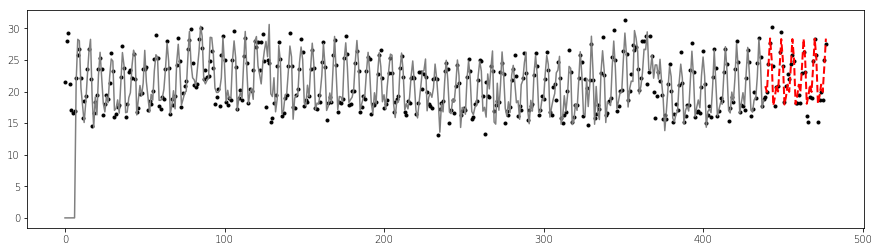

In [48]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
# Graph
fig, ax = plt.subplots(figsize=(15,4))
# # ax.xaxis.grid()
ax.plot(air['visit_mean'].values, 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], alpha=0.25)

In [50]:
y_train = air['visit_mean'][:-forecast_days]
y_cv = air['visit_mean'][-forecast_days:]
# y_train = air_sub[:-forecast_days]
# y_cv = air_sub[-forecast_days:]
# y_train = air.loc[:'2016-04-21','visit_mean']
# y_cv = air.loc['2016-04-22':'2016-05-30','visit_mean']
# y_train = air.loc[:'2016-12-25','visit_mean']
# y_cv = air.loc['2016-12-26':'2017-02-02','visit_mean']

In [51]:
display(y_train.tail(2))
display(y_cv.head(2))

visit_date
2017-03-13    17.643609
2017-03-14    18.795330
Name: visit_mean, dtype: float64

visit_date
2017-03-15    19.173025
2017-03-16    19.857332
Name: visit_mean, dtype: float64

In [52]:
display(predict.predicted_mean[:-forecast_days].tail(2))
display(predict.predicted_mean[-forecast_days:].head(2))

2017-03-13    17.360423
2017-03-14    18.617266
Freq: D, dtype: float64

2017-03-15    20.839412
2017-03-16    19.928540
Freq: D, dtype: float64

In [53]:
from sklearn.metrics import mean_squared_log_error 

print('Train accuracy: ',np.sqrt(mean_squared_log_error(y_train, 
                                                        predict.predicted_mean[:-forecast_days])))

print('Test accuracy: ',np.sqrt(mean_squared_log_error(y_cv, 
                                                       predict.predicted_mean[-forecast_days:])))

Train accuracy:  0.3996033798671128
Test accuracy:  0.08915426200113889


Text(0.5,1,'air_10bbe8acd943d8f6 visit by date')

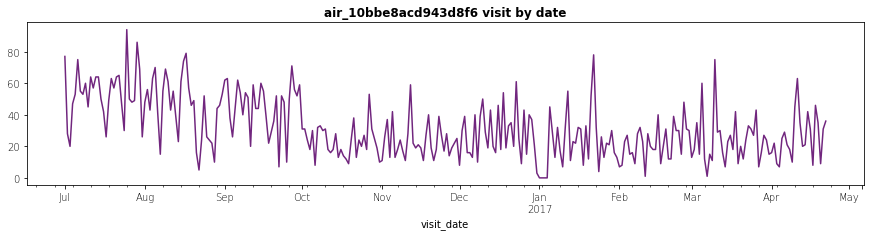

In [54]:
# Chose a random store and try to model
random_store = np.random.choice(air_visits.air_store_id.unique())
air_sub = air_visits[air_visits.air_store_id == random_store]
dates = air_sub.set_index('visit_date').resample('D').asfreq().index
air_sub = air_sub.set_index('visit_date').reindex(dates, fill_value=0)
air_sub = air_sub.visitors

air_sub.plot(figsize=(15,3))
plt.title('{} visit by date'.format(random_store))

In [55]:
train_visit_mean = air_sub[:-forecast_days]
cv_visit_mean = air_sub[-forecast_days:]

In [56]:
%%time
aic_full = ARIMA_grid_search(train_visit_mean)
display(aic_full)

,0,1,2,3,4,5
0,0.000000,2186.175338,2177.342672,2179.336577,2176.340811,2178.231448
1,2250.969603,2177.118762,2178.635922,2177.991632,2179.500276,2170.390497
2,2218.080176,2179.024663,2178.339000,2156.590234,2161.760469,2148.684677
3,2218.608354,2177.413958,2180.348281,2157.859109,2159.563144,2142.395111
4,2200.628165,2202.378235,NaN,2185.484450,2157.516183,2128.999453
5,2201.938852,2174.383090,NaN,NaN,2155.411565,2152.485061


CPU times: user 1min 53s, sys: 4.9 s, total: 1min 58s
Wall time: 22.1 s


In [57]:
aic_full = aic_full.stack().reset_index().rename(columns={'level_0':'p','level_1':'q',0:'AIC'})

In [58]:
p,q,_ = aic_full.iloc[np.argmin(aic_full.AIC[1:])]
print('p:',p,'q:',q)

p: 4.0 q: 5.0


In [59]:
mod = sm.tsa.statespace.SARIMAX(train_visit_mean,
                                    order=(int(p), 0, int(q)),
                                    trend='c',
                                    seasonal_order=(0,1,0,7))
res = mod.fit(disp=False)


In [60]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = 39
predict = res.get_prediction(end=mod.nobs+forecast_days-1 )

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

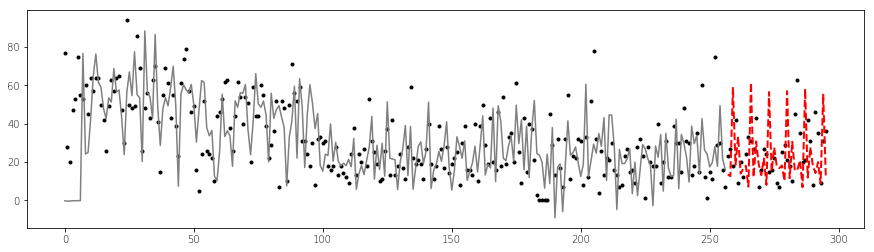

In [62]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
# Graph
fig, ax = plt.subplots(figsize=(15,4))
# # ax.xaxis.grid()
ax.plot(air_sub.values, 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], alpha=0.25)

In [66]:
y_train = air_sub[:-forecast_days]
y_cv = air_sub[-forecast_days:]
# y_train = air.loc[:'2016-04-21','visit_mean']
# y_cv = air.loc['2016-04-22':'2016-05-30','visit_mean']
# y_train = air.loc[:'2016-12-25','visit_mean']
# y_cv = air.loc['2016-12-26':'2017-02-02','visit_mean']

In [86]:
# clipped for redicilous values like -19 visits
y_hat = np.clip(predict.predicted_mean,a_min=0,a_max=y_train.max())

In [87]:
from sklearn.metrics import mean_squared_log_error 

print('Train accuracy: ',np.sqrt(mean_squared_log_error(y_train, 
                                                        y_hat[:-forecast_days].fillna(0))))

print('Test accuracy: ',np.sqrt(mean_squared_log_error(y_cv, 
                                                       y_hat[-forecast_days:].fillna(0))))

Train accuracy:  1.0343570214752633
Test accuracy:  0.8091057840811139


# ARIMA SUBMISSION 
private 0.931 public 0.787

REASONS OF FAILURE:
    - Aggregate data is dangerous. http://cfr.ivo-welch.info/readers/pub/cfr-028.pdf
    - Rely on plot rather than metric
    - Not every prediction model can be transferred from one context to another
    - Should use Vector ARIMA model
    - Parameters are not tuned properly, CV strategy is weak.

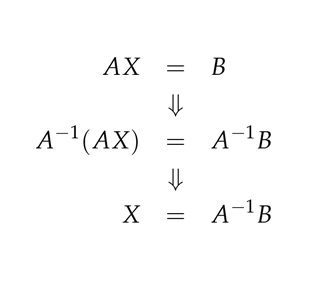

In [126]:
Image("./stored_files/matrix.png", width=300, height=300)

# 2. ii. Time series with PROPHET Library

which utilizes a Bayesian based curve fitting method to forecast the time series data. The cool thing about Prophet is that it doesn’t require much prior knowledge or experience of forecasting time series data since it automatically finds seasonal trends beneath the data and offers a set of ‘easy to understand’ parameters. Hence, it allows non statisticians to start using it and get reasonably good results that are often equal or sometimes even better than the ones produced by the experts.

# Example:

In [90]:
from fbprophet import Prophet

number_of_stores = test.air_store_id.nunique()

date_range = pd.date_range(start=pd.to_datetime('2016-07-01'),
                           end=pd.to_datetime('2017-04-22'))
forecast_days = (pd.to_datetime('2017-05-31')-pd.to_datetime('2017-04-22')).days

In [93]:
random_store = np.random.choice(air_visits.air_store_id.unique())

In [94]:
air_visits = air_visits.reset_index()
data = air_visits[air_visits['air_store_id'] == random_store]

In [95]:
# Ensure we have full range of dates.
data = data[['visit_date', 'visitors']].set_index('visit_date')
data = data.reindex(date_range).fillna(0).reset_index()
data.columns = ['ds', 'y']

In [96]:
# Rearrange holidays to fit prophet format
df_holidays = holidays[['visit_date','holiday_flg']]
df_holidays.columns = ['ds', 'holiday']
df_holidays = df_holidays[df_holidays['holiday'] == 1]
df_holidays['holiday'] = 'holiday'
# df_holidays

In [131]:
%%time
# This is used for suppressing prophet info messages.
# logging.getLogger('fbprophet.forecaster').propagate = False

m = Prophet(holidays=df_holidays,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False)
m.fit(data)
future = m.make_future_dataframe(forecast_days)
forecast = m.predict(future)

CPU times: user 4.35 s, sys: 120 ms, total: 4.47 s
Wall time: 2.3 s


In [133]:
4*800/60/60

0.888888888888889

In [106]:
# plt.figure(figsize=(10,3))
# fig2 = m.plot_components(forecast)

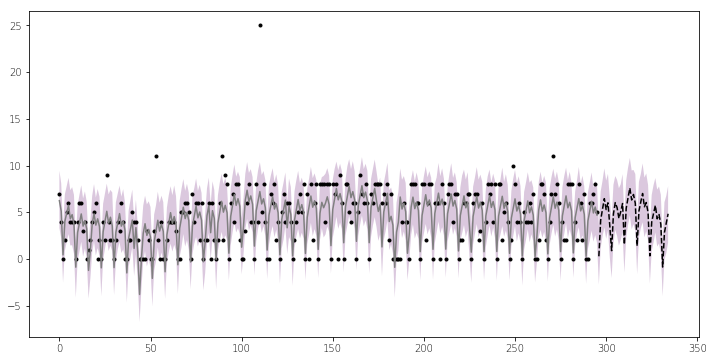

In [111]:
# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()

ax.plot(data['y'][-forecast.shape[0]+39:].reset_index(drop=True), 'k.')

# # Plot
# ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'gray')
# ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci.iloc[:, 0], predict_ci.iloc[:, 1], alpha=0.15)
forecast.yhat[:-39].plot(c='gray')
forecast.yhat[-39:].plot(linestyle='--',c='k')
ax.fill_between(range(335), forecast.yhat_lower, forecast.yhat_upper, alpha=0.25)


# ax.set(title='Figure 8.9 - Internet series');

# Model with all data

In [112]:
air_visits = pd.read_csv(os.path.join(path_input,'air_visit_data.csv.gz'))
air_reserve = pd.read_csv(os.path.join(path_input,'air_reserve.csv.gz'))
hpg_reserve = pd.read_csv(os.path.join(path_input,'hpg_reserve.csv.gz'))
air_store = pd.read_csv(os.path.join(path_input,'air_store_info.csv.gz'))
hpg_store = pd.read_csv(os.path.join(path_input,'hpg_store_info.csv.gz'))
holidays = pd.read_csv(os.path.join(path_input,'date_info.csv.gz'))
store_ids = pd.read_csv(os.path.join(path_input,'store_id_relation.csv.gz'))
test = pd.read_csv(os.path.join(path_input,'sample_submission.csv.gz'))

In [113]:
air_visits.visit_date = pd.to_datetime(air_visits.visit_date)

# air_visits_2017 = air_visits.set_index('visit_date')
# air_visits_2017 = air_visits_2017.loc['2017']
# air_visits_2017 = air_visits_2017.reset_index()
#log transform
# air_visits_2017['visitors'] = np.log1p(air_visits_2017['visitors'])

# date_range = pd.date_range(start=pd.to_datetime('2017-01-01'),
#                            end=pd.to_datetime('2017-04-22'))

date_range = pd.date_range(start=pd.to_datetime('2016-07-01'),
                           end=pd.to_datetime('2017-04-22'))

forecast_range = pd.date_range(start=pd.to_datetime('2017-04-23'),
                           end=pd.to_datetime('2017-05-31'))

forecast_days = len(forecast_range)

train = pd.DataFrame(
    index=date_range, columns=air_visits.air_store_id.unique())

train = train.unstack().reset_index()

train.columns = ['air_store_id', 'visit_date', 0]

train = train.merge(air_visits, on=['air_store_id', 'visit_date'], how='left')[
    ['air_store_id', 'visit_date', 'visitors']]

train = train.fillna(0)

train = train.set_index(['air_store_id', 'visit_date']).unstack()


In [119]:
train.head()

visitors                                              \
visit_date           2016-07-01 2016-07-02 2016-07-03 2016-07-04 2016-07-05   
air_store_id                                                                  
air_00a91d42b08b08d9       35.0        9.0        0.0       20.0       25.0   
air_0164b9927d20bcc3        0.0        0.0        0.0        0.0        0.0   
air_0241aa3964b7f861       10.0       13.0       20.0        4.0        7.0   
air_0328696196e46f18        0.0        0.0       11.0        4.0        6.0   
air_034a3d5b40d5b1b1       19.0       23.0        5.0       13.0        0.0   

                                                                             \
visit_date           2016-07-06 2016-07-07 2016-07-08 2016-07-09 2016-07-10   
air_store_id                                                                  
air_00a91d42b08b08d9       29.0       34.0       42.0       11.0        0.0   
air_0164b9927d20bcc3        0.0        0.0        0.0        0.0        0.0   
air_0241aa3964b7f861       10.0        1.0        2.0        7.0        3.0   
air_0328696196e46f18        4.0        8.0        8.0       12.0        4.0   
air_034a3d5b40d5b1b1       10.0        3.0       23.0       12.0       13.0   

                        ...                                                  \
visit_date              ...     2017-04-13 2017-04-14 2017-04-15 2017-04-16   
air_store_id            ...                                                   
air_00a91d42b08b08d9    ...           34.0       39.0        0.0        0.0   
air_0164b9927d20bcc3    ...           13.0        7.0        1.0        0.0   
air_0241aa3964b7f861    ...            0.0        4.0       15.0       10.0   
air_0328696196e46f18    ...            0.0        9.0        4.0        3.0   
air_034a3d5b40d5b1b1    ...           22.0       18.0       31.0       39.0   

                                                                             \
visit_date           2017-04-17 2017-04-18 2017-04-19 2017-04-20 2017-04-21   
air_store_id                                                                  
air_00a91d42b08b08d9       19.0       35.0       17.0       38.0       55.0   
air_0164b9927d20bcc3        2.0        1.0        8.0        1.0       26.0   
air_0241aa3964b7f861       12.0       19.0        8.0        0.0        3.0   
air_0328696196e46f18        3.0        0.0       24.0        0.0       19.0   
air_034a3d5b40d5b1b1       25.0       20.0       31.0       12.0       37.0   

                                 
visit_date           2017-04-22  
air_store_id                     
air_00a91d42b08b08d9       18.0  
air_0164b9927d20bcc3        6.0  
air_0241aa3964b7f861       13.0  
air_0328696196e46f18        8.0  
air_034a3d5b40d5b1b1       35.0  

[5 rows x 296 columns]

In [114]:
# number_of_stores = test.air_store_id.nunique()
# Rearrange holidays to fit prophet format
holidays = holidays.rename(columns={'calendar_date':'visit_date'})
df_holidays = holidays[['visit_date','holiday_flg']]
df_holidays.columns = ['ds', 'holiday']
df_holidays = df_holidays[df_holidays['holiday'] == 1]
df_holidays['holiday'] = 'holiday'
# df_holidays

In [115]:
def forecast_prophet(X):
    data = X.reset_index()
    store_id = data.columns[2]
    data = data.iloc[:,1:]
    data.columns = ['ds', 'y']
    m = Prophet(holidays=df_holidays)
    m.fit(data)
    future = m.make_future_dataframe(forecast_days)
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']]
    forecast.columns = ['id', 'visitors']
#     forecast['id'] = forecast['id'].apply(lambda x:'%s_%s'%(store_id, x.strftime('%Y-%m-%d')))
#     forecast = forecast.set_index('id')
#     display(forecast.head())
#     global test_prophet
#     test_prophet.update(forecast)
#     return forecast.visitors.values[-forecast_days:]
    return forecast.visitors[-forecast_days:]

cores = multiprocessing.cpu_count()
# cores =2 

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, cores)
    pool = Pool(cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df
    
def apply_prophet(df):
    forecast =  df.apply(lambda x: forecast_prophet(x),axis=1)
    return forecast

In [116]:
%%time
# This is used for suppressing prophet info messages.
logging.getLogger('fbprophet.forecaster').propagate = False

df_forecast_prophet = parallelize_dataframe(train, apply_prophet)

CPU times: user 320 ms, sys: 521 ms, total: 841 ms
Wall time: 1min 41s


In [117]:
df_forecast_prophet.columns = [e.strftime('%Y-%m-%d') for e in forecast_range]

df_forecast_prophet = df_forecast_prophet.stack().reset_index()

df_forecast_prophet['id'] = df_forecast_prophet.apply(lambda x:'%s_%s'%(x['air_store_id'], x['level_1']),axis=1)

df_forecast_prophet = df_forecast_prophet.rename(columns={0:'visitors'})

df_forecast_prophet = df_forecast_prophet[['id','visitors']].set_index('id')

test_prophet = test.set_index('id').copy()

test_prophet.update(df_forecast_prophet)

In [ ]:
# test_prophet.reset_index()[['id','visitors']].to_csv('./submissions/parallel_prophet_short.csv', index=False)

In [118]:
!head submissions/parallel_prophet.csv

id,visitors
air_00a91d42b08b08d9_2017-04-23,3.2018026740179337
air_00a91d42b08b08d9_2017-04-24,24.32484745610509
air_00a91d42b08b08d9_2017-04-25,25.84947162712326
air_00a91d42b08b08d9_2017-04-26,29.44563309755569
air_00a91d42b08b08d9_2017-04-27,31.16176619899006
air_00a91d42b08b08d9_2017-04-28,37.09055580270294
air_00a91d42b08b08d9_2017-04-29,-3.733114353924215
air_00a91d42b08b08d9_2017-04-30,3.3075055441819146
air_00a91d42b08b08d9_2017-05-01,24.43055032626438


# Prophet Submission
private:0.600  public:0.542

### ref

https://machinelearningmastery.com/time-series-data-stationary-python/